# Calculating Barriers in Metal - Semiconductor junctions 
- all calculations indepandant of the material
- for both p and n-type


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import os
import pandas as pd

### Physical Constants

In [44]:
Q = 1.602e-19  # Elementary charge (C)
EPSILON_0_cm = 8.854e-14  # Permittivity of free space (As/Vcm) -> in cm here to math the doping concentration units
EPSILON_0_m = 8.854e-12  # Permittivity of free space (As/Vcm) -> in cm here to math the doping concentration units
K_B_eV = 8.617e-5  # Boltzmann constant (eV/K)
K_B_J = 1.380649e-23  # Boltzmann constant (J/K)
T = 300  # Temperature (K)
H = 6.626e-34# planck constant (Js)
m_e = 9.109e-31  # Electron mass (kg)

### Material Parameters Class
allows for easier swaps of materials

In [45]:
class MaterialParameters:
    """Stores and manages the material parameters for the semiconductor and metal."""
    def __init__(self, name, type, phi_s, chi=None, Nd_or_Na=None, epsilon_r=None, Nc=None, Nv=None, phi_0_CNL=None):
        """
        :param name: Material name (e.g., 'Silicon', 'Aluminium').
        :param type: 'n' or 'p' for semiconductor, 'metal' for metal.
        :param phi_s: Work function (eV) for metal OR band gap (Eg) for semiconductor.
        :param chi: Electron Affinity (eV) for semiconductor.
        :param Nd_or_Na: Donor (Nd) or Acceptor (Na) concentration (atoms/cm^3) for semiconductor.
        :param epsilon_r: Relative permittivity (dielectric constant).
        :param Nc: Effective Density of States in Conduction Band (cm^-3).
        :param Nv: Effective Density of States in Valence Band (cm^-3).
        :param phi_0_CNL: charge neutrality level (eV).
        """
        self.name = name
        self.type = type
        self.phi_s = phi_s # Work function or Eg
        self.chi = chi
        self.Nd_or_Na = Nd_or_Na
        self.epsilon_r = epsilon_r
        # Calculate absolute permittivity (F/cm)
        if self.epsilon_r is not None: 
            self.epsilon_cm = self.epsilon_r * EPSILON_0_cm
            self.epsilon_m = self.epsilon_r * EPSILON_0_m
        
        self.Nc = Nc
        self.Nv = Nv
        self.phi_0_CNL = phi_0_CNL

### Junction Calculation Class
- ideal barrier
- fermi level pinning
- depletion width

In [ ]:
class JunctionCalculator:
    """Performs calculations for the metal-semiconductor junction."""

    def __init__(self, metal, semiconductor):
        self.metal = metal
        self.semiconductor = semiconductor
        self.type = semiconductor.type.lower() # 'n' or 'p'


    def _calculate_fermi_level_position(self):
        """
        Calculates the Fermi level position relative to the band edge (in eV).
        This result is E_c - E_F for n-type or E_F - E_v for p-type.
        """
        kBT_over_q = K_B_eV * T # k_B T/q (in Volts)

        if self.type == 'n':
            # E_C-E_F = k_B T/q * ln (N_D/N_C) (in V)
                        
            # NOTE: We must ensure N_D < N_C for the Boltzmann approximation to be valid
            N_D = self.semiconductor.Nd_or_Na
            N_C = self.semiconductor.Nc
            
            if N_D > N_C:
                # Fermi level is in the conduction band (degenerate case)
                print("n--- WARNING: Degenerate doping (ND > NC). Result may be inaccurate. ---")
            
            V_n = kBT_over_q * np.log(self.semiconductor.Nc / N_D)
            return V_n
            
        elif self.type == 'p':
            # E_F - E_V = k_B T/q * ln(N_A/N_V) (in V)
            N_A = self.semiconductor.Nd_or_Na
            N_V = self.semiconductor.Nv

            if N_A > N_V:
                print("n--- WARNING: Degenerate doping (NA > NV). Result may be inaccurate. ---")
                
            V_p = kBT_over_q * np.log(self.semiconductor.Nv / N_A)
            return V_p
        
        else:
            raise ValueError("Semiconductor type must be 'n' or 'p'.")


    def _calculate_v_bi(self):
            """
            Calculates the built-in potential (V_bi) based on the Schottky-Mott model:
            V_bi = 1/q * (Phi_m - Phi_s), where Phi_s is the semiconductor work function.
            
            V_bi (n-type) = Phi_m - chi - V_n       (in Volts)
            V_bi (p-type) = Phi_m - chi - E_g + V_p (in Volts)
            
            Where Phi_m, chi, E_g are in eV and V_n, V_p are in Volts.
            Since V_n and V_p are already calculated in Volts, the formula simplifies.
            """
            phi_m = self.metal.phi_s        # Phi_m (eV)
            chi = self.semiconductor.chi    # chi (eV)
            Eg = self.semiconductor.phi_s   # E_g (eV)

            # Fermi level position relative to band edge, V_n or V_p (in Volts)
            V_fermi_band_edge = self._calculate_fermi_level_position() 

            if self.type == 'n':
                # The semiconductor work function is Phi_s = chi + (E_c - E_F)/q = chi + V_n
                # V_bi = (Phi_m - Phi_s)/q
                # V_bi = Phi_m - chi - V_fermi_band_edge
                V_bi = phi_m - chi - V_fermi_band_edge
                
            elif self.type == 'p':
                # The semiconductor work function is Phi_s = chi + E_g - (E_F - E_v)/q = chi + E_g - V_p
                # V_bi = Phi_m - (chi + E_g - V_fermi_band_edge)
                V_bi = phi_m - (chi + Eg - V_fermi_band_edge)
            
            else:
                raise ValueError("Semiconductor type must be 'n' or 'p'.")
                
            return V_bi



    def ideal_barrier_height(self):
            """
            Calculates the ideal Schottky Barrier Height Phi_B,ideal
            """
            phi_m = self.metal.phi_s # Metal work function (eV)
            chi = self.semiconductor.chi # Electron Affinity (eV)
            
            if self.type == 'n':
                # Phi_{Bn, ideal} = Phi_m - chi
                phi_b_ideal = phi_m - chi
            elif self.type == 'p':
                Eg = self.semiconductor.phi_s # Band gap (eV)
                # Phi_{Bp, ideal} = E_g - (Phi_m - chi)
                phi_b_ideal = Eg - (phi_m - chi)
            else:
                raise ValueError("Semiconductor type must be 'n' or 'p'")

            return phi_b_ideal
        
        
    def barrier_height_pinning(self, S):
        """
        Calculates the barrier height with Fermi Level Pinning
        :param S: Pinning factor (0 < S < 1). S=1 is ideal, S=0 is full pinning.
        """
        phi_m = self.metal.phi_s # Metal work function (eV)
        chi = self.semiconductor.chi # Electron Affinity (eV)
        phi_0_CNL = self.semiconductor.phi_0_CNL # charge neutrality level (eV)
        E_g = self.semiconductor.phi_s # Band gap (eV)

        if self.type == 'n':
            Phi_B = S * (phi_m - chi) + (1 - S) * (E_g - phi_0_CNL)         # phi_0_CNL energy difference between the conduction band minimum and the CNL
        elif self.type == 'p':
            Phi_B = S * (E_g + chi - phi_m) + (1 - S) * phi_0_CNL           # phi_0_CNL energy difference between the valence band maximum and the CNL
        else:
            raise ValueError("Semiconductor type must be 'n' or 'p'")

        return Phi_B


    def depletion_width(self, V_ext=0):
            """
            Calculates the depletion width (W) at a given applied voltage (V_ext).
            Requires the built-in voltage (V_bi).
            """
            V_bi = self._calculate_v_bi()
            N = self.semiconductor.Nd_or_Na
            epsilon = self.semiconductor.epsilon_cm

            # W = sqrt{2 epsilon (V_bi - V_a)/Q N}
            try:
                W = np.sqrt((2 * epsilon * (V_bi - V_ext)) / (Q * N))
            except ValueError:
                print("Error: (V_bi - V_ext) is negative. Check inputs or V_bi calculation.")
                W = 0
                
            return W * 1e7 # Convert cm to nm
        
        
    def calculate_tunneling_factor(type, Nd_or_Na, epsilon):
        #  https://www.ioffe.ru/SVA/NSM/Semicond/SiC/basic.html  / https://www.ioffe.ru/SVA/NSM/Semicond/SiC/bandstr.html
        m_n = 0.37 * m_e    # Effective mass of the density of states in one valley of conduction band mc
        m_p = 1.0 * m_e     # Effective mass of density of state mv  
        
        Nd_or_Na = Nd_or_Na * 1e6 # in m^-3
        
        if type == 'n':
            E_00 = (H*Q)/(4*np.pi) * np.sqrt(Nd_or_Na/(m_n*epsilon))
        elif type == 'p':
            E_00 = (H*Q)/(4*np.pi) * np.sqrt(Nd_or_Na/(m_p*epsilon))
            
        tunneling_factor = E_00 / (K_B_J * T)
        return tunneling_factor

<div>
<img src="Output/n_barrier_pinning.png" width="450"/>   <img src="Output/p_barrier.png" width="450"/>
</div>

# Testing

## Material definitions

In [47]:
# def SiC parameters
n_SiC = MaterialParameters(
    name='n-SiC',
    type='n',
    phi_s=3.26, # Eg (eV)
    chi=3.2,
    Nd_or_Na=4.33e17,
    epsilon_r=9.7,
    Nc=1.7e19,
    Nv=2.5e19,
    phi_0_CNL=1.51)

p_SiC = MaterialParameters(
    name='p-SiC',
    type='p',
    phi_s=3.26, # Eg (eV)
    chi=3.2,
    Nd_or_Na=1e19,
    epsilon_r=9.7,
    Nc=1.7e19,
    Nv=2.5e19,
    phi_0_CNL=1.51)

# ------------------------------------------------------------------

Ni2Si = MaterialParameters(
    name='Ni2Si',
    type='metal',
    phi_s=4.8,  # 4.6-4.8 eV
)

Ni = MaterialParameters(
    name='Ni',
    type='metal',
    phi_s=5.05, # 5.04 – 5.35 eV
)

Ti = MaterialParameters(
    name='Ti',
    type='metal',
    phi_s=4.33,
)

Al = MaterialParameters(
    name='Al',
    type='metal',
    phi_s=4.08, # 4.06 to 4.28 eV, though the exact value varies depending on the specific crystal face and surface conditions
)

TiNi = MaterialParameters(
    name='TiNi',
    type='metal',
    phi_s=4.15, # 4.15-4.1
)

TiAl = MaterialParameters(
    name='TiAl',
    type='metal',
    phi_s=4.8,
)

TiC = MaterialParameters(
    name='TiC',
    type='metal',
    phi_s=4.25,  # 4.1-4.4 eV
)

Ti3SiC2 = MaterialParameters(
    name='Ti3SiC2',
    type='metal',
    phi_s=4.6,  # Ti₃SiC₂ MAX phase 4.5-4.7 eV
)

NiGe = MaterialParameters(
    name='NiGe',
    type='metal',
    phi_s=4.6,  # 4.6-4.8 eV increases with Ni content
)

print(n_SiC.__dict__)
print(Ni2Si.__dict__)

{'name': 'n-SiC', 'type': 'n', 'phi_s': 3.26, 'chi': 3.2, 'Nd_or_Na': 4.33e+17, 'epsilon_r': 9.7, 'epsilon_cm': 8.588379999999999e-13, 'epsilon_m': 8.588379999999999e-11, 'Nc': 1.7e+19, 'Nv': 2.5e+19, 'phi_0_CNL': 1.51}
{'name': 'Ni2Si', 'type': 'metal', 'phi_s': 4.8, 'chi': None, 'Nd_or_Na': None, 'epsilon_r': None, 'Nc': None, 'Nv': None, 'phi_0_CNL': None}


# Schottky-Mott Model

In [49]:
list_of_semiconductors = [n_SiC, p_SiC]
list_of_metals = [Ni2Si, Ni, Ti, Al, TiNi, TiAl, TiC, Ti3SiC2, NiGe]

all_barriers_data = []
for semiconductor in list_of_semiconductors:
    print(semiconductor.name)
    for metal in list_of_metals:
        phi_b = JunctionCalculator(metal, semiconductor).ideal_barrier_height()
        # print(f"Barrier Height ({semiconductor.name}/{metal.name}): {round(phi_m, 3)} eV")
        
        # using full pinning
        phi_b_pinning = JunctionCalculator(metal, semiconductor).barrier_height_pinning(1)

        w_scr = JunctionCalculator(metal, semiconductor).depletion_width()
        # print(f"work function ({semiconductor.name}/{metal.name}): {round(w_scr, 3)} nm")
        row_data = {
            'Semiconductor': semiconductor.name,
            'Metal': metal.name,
            'Barrier_Height_eV': round(phi_b, 3),
            'Pinning_Barrier_Height_eV': round(phi_b_pinning, 3),
            'Depletion_Width_nm': round(w_scr, 3),
            # 'Tunneling_Factor': round(JunctionCalculator.calculate_tunneling_factor(semiconductor.type, semiconductor.Nd_or_Na, semiconductor.epsilon_m), 3)
        }
        all_barriers_data.append(row_data)

barriers = pd.DataFrame(all_barriers_data)
print(barriers)

n-SiC
p-SiC
   Semiconductor    Metal  Barrier_Height_eV  Pinning_Barrier_Height_eV  \
0          n-SiC    Ni2Si               1.60                       1.60   
1          n-SiC       Ni               1.85                       1.85   
2          n-SiC       Ti               1.13                       1.13   
3          n-SiC       Al               0.88                       0.88   
4          n-SiC     TiNi               0.95                       0.95   
5          n-SiC     TiAl               1.60                       1.60   
6          n-SiC      TiC               1.05                       1.05   
7          n-SiC  Ti3SiC2               1.40                       1.40   
8          n-SiC     NiGe               1.40                       1.40   
9          p-SiC    Ni2Si               1.66                       1.66   
10         p-SiC       Ni               1.41                       1.41   
11         p-SiC       Ti               2.13                       2.13   
12         p-

C:\Users\lhage\AppData\Local\Temp\ipykernel_7192\1922200919.py:133: RuntimeWarning: invalid value encountered in sqrt
  W = np.sqrt((2 * epsilon * (V_bi - V_ext)) / (Q * N))


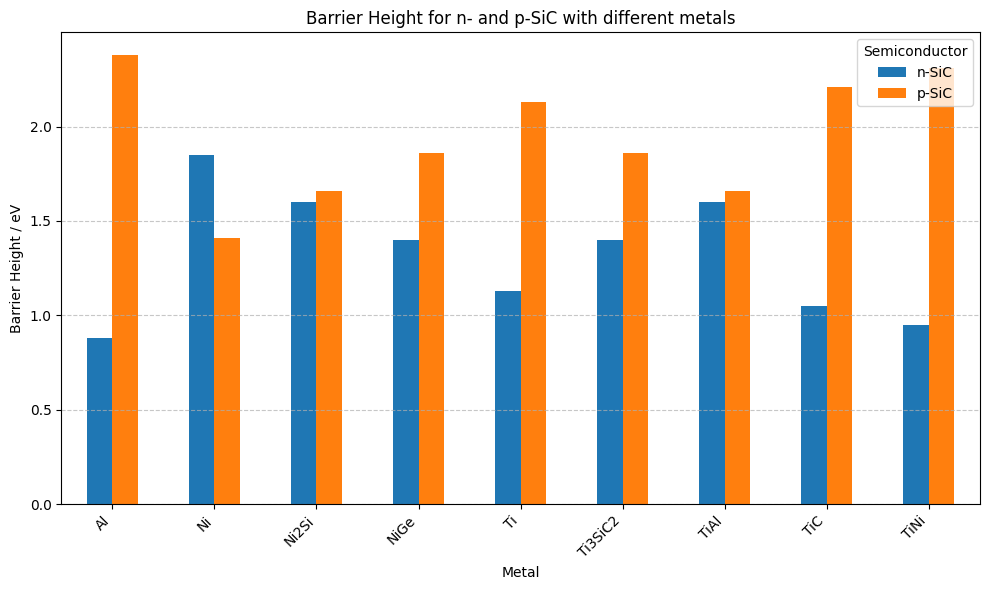

In [13]:
# Pivot for grouped plotting
pivot_df = barriers.pivot(index="Metal", columns="Semiconductor", values="Barrier_Height_eV")
# print(pivot_df)

pivot_df.plot(kind="bar", figsize=(10, 6))
plt.title("Barrier Height for n- and p-SiC with different metals")
plt.ylabel("Barrier Height / eV")
plt.xlabel("Metal")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Semiconductor")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

In [51]:
# # make a sweep of the pinning factor S from 0 to 1
# S_values = np.linspace(0, 1, 100)
# phi_b_pinning = [JunctionCalculator(Ni2Si, n_SiC).barrier_height_pinning(s) for s in S_values]
# print(phi_b_pinning)

# plt.plot(S_values, phi_b_pinning)
# plt.xlabel('Pinning Factor (S)')
# plt.ylabel('Barrier Height (eV)')
# plt.grid()
# plt.show()

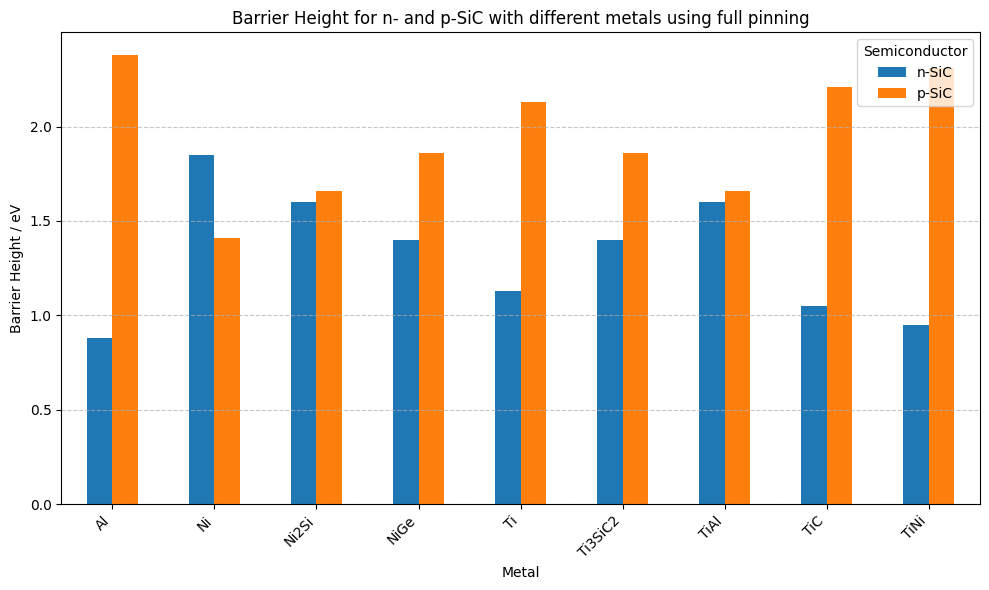

In [17]:
# Pivot for grouped plotting
pivot_df = barriers.pivot(index="Metal", columns="Semiconductor", values="Pinning_Barrier_Height_eV")
# print(pivot_df)

pivot_df.plot(kind="bar", figsize=(10, 6))
plt.title("Barrier Height for n- and p-SiC with different metals using full pinning")
plt.ylabel("Barrier Height / eV")
plt.xlabel("Metal")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Semiconductor")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

maybe make plot using the density of interface states vs. the barrier hight

### current transport mechanisms :
$R_c \propto \exp\left(\frac{q\Phi_B}{\sqrt{N}}\right)$

calculate specific tunneling factor $\frac{qE_{00}}{{k_BT}}$ with $E_{00} = \frac{h \cdot q}{4\cdot \pi} \cdot \sqrt{\frac{N}{m^*\epsilon_r}}$\
=> indicates relevance of TE vs. FE mechanisms
| Padovani-Stratton parameter    | dominant transport mechanism |
| ----- | ------------------------------ |
|< 1    | Thermionic Emission (TE)       |
|1 < 2  | Thermionic-Field Emission (TFE)|
|\> 2   | Field Emission (FE)            |

In [56]:
padovani_n = JunctionCalculator.calculate_tunneling_factor(n_SiC.type, n_SiC.Nd_or_Na, n_SiC.epsilon_m)
padovani_p = JunctionCalculator.calculate_tunneling_factor(p_SiC.type, p_SiC.Nd_or_Na, p_SiC.epsilon_m)
print(f"Padovani-Stratton parameter n-SiC: {padovani_n}")
print(f"Padovani-Stratton parameter p-SiC: {padovani_p}")

Padovani-Stratton parameter n-SiC: 0.24943170250861876
Padovani-Stratton parameter p-SiC: 0.72913603941474


In [ ]:
# def main():
#     print("Metal-Semiconductor Junction Calculator")
#     pass


# if __name__ == "__main__":
#     main()